# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
import glob
import csv

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
# Load pickled data
training_file = "./data/train.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# if tqdm is not installed
!pip install tqdm

    100% |################################| 51kB 1.2MB/s 
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from tqdm import tqdm

In [5]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

### Before getting started, in order to get reproducible results let us 
### initialize random number generator with a fixed seed
import random
import cv2
random.seed(10)

> Let us start by plotting some random sign to verify that data set is loaded correctly

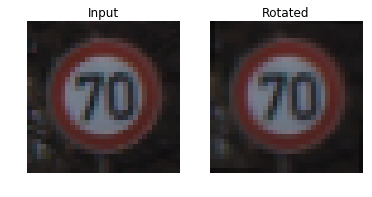

In [7]:
def rotation_transform(img):
    rows,cols,ch = img.shape
    angle = np.random.randint(-3,3)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst_1 = cv2.warpAffine(img,M,(cols,rows))
    return dst_1

plt.subplot(121)
plt.imshow((X_test[701]))
plt.axis('off')
plt.title('Input')
plt.subplot(122)
plt.imshow(rotation_transform(X_test[701]))
plt.axis('off')
plt.title('Rotated')
plt.show()

> Plot some more random samples

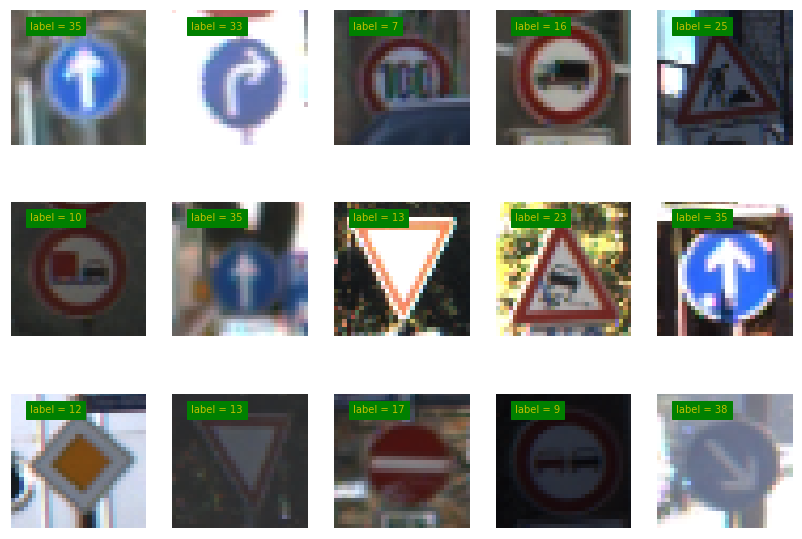

In [8]:
def plot_sample(X,y):
    number_rows = 3
    number_cols = 5
    plt.figure(figsize = (14,10))

    for i in range(number_rows*number_cols):
        ax1 = plt.subplot(3,5,i+1)
        ax1.axis("off")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        sample_image = np.random.randint(1,len(y))
        plt.imshow(X[sample_image])
        plt.text(4,4,"label = "+str(y[sample_image]),color='y',backgroundcolor='g')
    plt.show()

plot_sample(X_train,y_train)

> Now let us plot the histogram of classes distribution to see if the classes are balanced or we have some classes with lots of examples and some classes with quite few examples

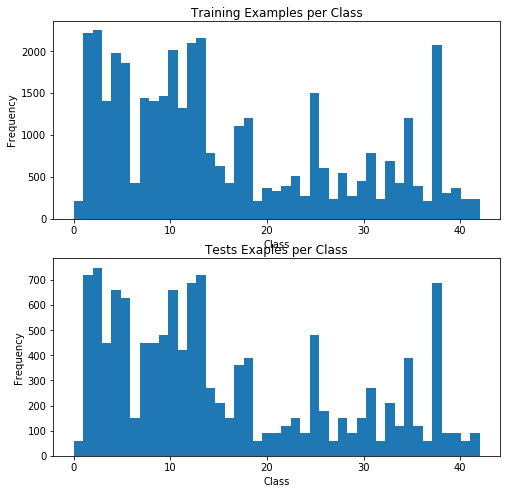

In [9]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(y_train, bins=n_classes)
plt.title('Training Examples per Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.subplot(2,1,2)
plt.hist(y_test, bins=n_classes)
plt.title('Tests Exaples per Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

> One can immediately see that examples distribution is highly unbalanced. This is an important observation that can have an effect of how the data must be augmented. It might be better to have balanced dataset after data augmentation step. In what follows I will augment data without any balancing by augmenting each class with a fixed number of elements independently of the information that inverted histogram can give. Later on I will use keras data augmentation module and compare the results. One fo the reasons for not balancing could be that in real life signs distribution is not balanced either.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Data transformatoin and data augmentation step

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

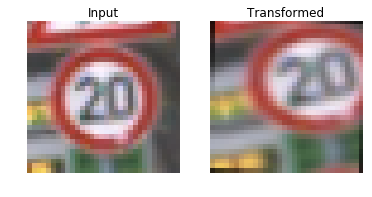

In [11]:
def affine_transform(img):
    rows,cols,ch = img.shape    
    shear_range = 10
    trans_range = 5

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Transformatoin
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,Trans_M,(cols,rows))
    dst = cv2.warpAffine(img,shear_M,(cols,rows))

    return dst

def pad_image(image,pad):
    height, width, channles = image.shape
    new_dim = height + 2*pad
    frame = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_DEFAULT)
    return frame

def generate_jitter(image):
    height, width, channles = image.shape
    # add padding and copy img into center
    pad = 8
    frame = pad_image(image, pad)
    # rotate image
    frame = rotation_transform(frame)
    # affine transform
    frame = affine_transform(frame)  
    # extract from center
    result = frame[pad:pad + 32, pad:pad + 32]
    # add noise: TODO, skipped for now
        
    return result

img = generate_jitter(X_train[10])
plt.subplot(121)
plt.imshow((X_train[10]))
plt.axis('off')
plt.title('Input')
plt.subplot(122)
plt.imshow(rotation_transform(img))
plt.axis('off')
plt.title('Transformed')
plt.show()

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
> Data preprocessing pipeline will include the following steps:
0. As a zero step, during data load I scale all images by 255, to scale data to the interval of [0,1]
1. Resize image
2. Rotate image for a randomly generated angle 
3. Apply additional affine transform such as:
 a. Random translation
 b. Shear, which is effectively a linear map that displaces each point in fixed direction
4. Cut the center of the image of the size of 32x32 to remove broken borders due to rotation and shear

This can be summarized as adding jitter.

_I will not manually select the color space. Instead of manually selection of the color space I will introduce a degenerate convolution layer as a first layer of the deep convnet, that would effectively function as automatic color space selection_

In [12]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from tqdm import tqdm
n_train = len(X_train)
X_large_train = np.resize(X_train, (n_train * 3, 32, 32, 3))
y_large_train = np.resize(y_train, n_train * 3)

for i in tqdm(range(n_train)):
    for j in range(1, 3):
        new_index = j * n_train + i
        X_large_train[new_index] = generate_jitter(X_train[i])
        y_large_train[new_index] = y_train[i]

print('Size of the augmented data set is {}'.format(len(X_large_train)))

100%|██████████| 39209/39209 [00:08<00:00, 4783.53it/s]

Size of the augmented data set is 117627


In [13]:
### In order to overfit for test data, we, as usual, split train dataset
### in train and validation datasets.
### Split is done by sci-kit learn train_test_split function
from sklearn.model_selection import train_test_split
training_features, valid_features, training_labels, valid_labels = train_test_split(
            X_large_train,
            y_large_train,
            test_size=0.15,
            random_state=10)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. _Splitting data into training and validation set:_ In order to validate performance of the model during training the training data set was split in two parts: training and validation set using the sci-kit learn _train_test_split_ with the validation set being 15% of the available data. 

2. _Data augmentation:_ Since the amount of training data is rather limited additional training data was generated by using the image augmentation steps outlined above. For each image in the original training set, 3 additional transformed images were generated. It is important to note that after image generation class distribution remains unbalanced. One of the reasoning could be that in real life some signs appear much more frequent than the others. (I have tried to balance the class distribution after image augmentation, this leads to a little gain in accuracy.)

In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Model definition in Tensorflow.

Later I will also use Keras with its data augmentation module and compare the results

In [15]:
### Define your architecture here.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

# Moments
mu = 0
sigma = 0.1

# Layer 0: Convolution. Input = 32x32x3. Output = 32x32x3.
conv0_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, 3), mean = mu, stddev = sigma))
conv0_b = tf.Variable(tf.zeros(3))
conv0   = tf.nn.conv2d(x, conv0_W, strides=[1, 1, 1, 1], padding='VALID') + conv0_b

# Layer 1: Convolution. 
conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(32))
conv1   = tf.nn.conv2d(conv0, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
# Activation.
conv1 = tf.nn.relu(conv1)

# Layer 2: Convolution.
conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(32))
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
# Activation.
conv2 = tf.nn.relu(conv2)
# Pooling. 
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
# Dropout
conv2 = tf.nn.dropout(conv2, keep_prob)

# Layer 3: Convolution. 
conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
conv3_b = tf.Variable(tf.zeros(64))
conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
# Activation.
conv3 = tf.nn.relu(conv3)
# Pooling. 
conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
# Dropout
conv3 = tf.nn.dropout(conv3, keep_prob)


# Flatten.
fc0   = flatten(conv3)

dense_layer1 = 2304

# Store layers weight & bias
weights = {
    'hidden_layer': tf.Variable(tf.truncated_normal(shape=(dense_layer1, dense_layer1), mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(dense_layer1, n_classes), mean = mu, stddev = sigma)),
}
biases = {
    'hidden_layer': tf.Variable(tf.zeros(dense_layer1)),
    'out': tf.Variable(tf.zeros(n_classes)),
}

# Layer 3: Fully Connected.
fc1 = tf.matmul(fc0, weights['hidden_layer']) + biases['hidden_layer']

# Activation.
fc1 = tf.nn.relu(fc1)
fc1 = tf.nn.dropout(fc1, keep_prob)


# Layer 5: Fully Connected. Output = Number of classes
logits = tf.matmul(fc1, weights['out']) + biases['out']

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The structure of the network that I use is the following:

0. Convolution with a degenerate kernel (it is done to allow the network to "automatically" select the correct color space
1. Convolution with Kernel of size 3. Depth 32
 1. ReLU
2. Convolution with Kernel of size 3. Depth 32
 1. ReLU
 2. Pooling
 3. Dropout
3. Convolution with Kernel of size 3, Depth 64
 1. ReLU
 2. Pooling
 3. Dropout
4. Flatenning layer
 1. ReLU
 2. Dropout
5. FC

During experiments I figured out that having the degenerate convolution as the first layer works better than in the case if I try to select the color space manually. I have tried to use less FC layers (since they are slow to compute and tend to lead to overfitting) and use mainly convolution layers followed by ReLU nonlinearity and dropouts to prevent overfitting.

The straightforward usage of LeNet architecture gave me 87% of accuracy right from the start. Architecture that I use here gives up to almost 98-99% of accuracy if used with smart data augmentation.

### Training of convnet in Tensorflow

In [16]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        a, l = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (a * len(batch_x))
        total_loss += (l * len(batch_x))
        
    return (total_accuracy / num_examples, total_loss / num_examples)

In [27]:
### Train your model here.

# Define number of epochs, batch size and learning rate
EPOCHS = 30
BATCH_SIZE = 50
rate = 0.001

# Define weight for l2 regularization
beta = 0.001

# Define probability for dropout
dropout_keep_prob = 0.5

# Define name used to store the model
model_name = 'tf_model'

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
loss_operation = (loss_operation +
            (beta * tf.nn.l2_loss(weights["hidden_layer"])) + (beta * tf.nn.l2_loss(biases["hidden_layer"])) + 
            (beta * tf.nn.l2_loss(weights["out"])) + (beta * tf.nn.l2_loss(biases["out"])))
    
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
minimize_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

hist_train_loss = []
hist_valid_loss = []
hist_train_acc = []
hist_valid_acc = []

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(training_features)
    
    for i in tqdm(range(EPOCHS)):
        # it is important to shuffle on each step
        training_features, training_labels = shuffle(training_features, training_labels)
        total_accuracy = 0
        total_loss = 0
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = training_features[offset:end], training_labels[offset:end]
            sess.run(minimize_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_keep_prob})
            a, l = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_accuracy += (a * len(batch_x))
            total_loss += (l * len(batch_x))
            
        train_accuracy = total_accuracy / num_examples
        train_loss = total_loss / num_examples
        hist_train_acc.append(train_accuracy)
        hist_train_loss.append(train_loss)  
        (validation_accuracy, validation_loss) = evaluate(valid_features, valid_labels)
        hist_valid_acc.append(validation_accuracy)
        hist_valid_loss.append(validation_loss)
        
    saver = tf.train.Saver()
    saver.save(sess, model_name)

100%|██████████| 30/30 [10:50<00:00, 21.65s/it]


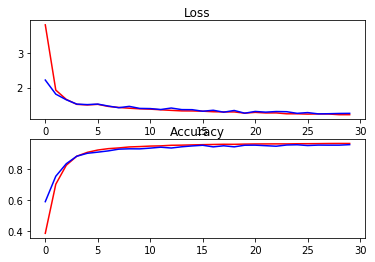

In [28]:
### Visualize training progress
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(range(0, len(hist_train_loss)), hist_train_loss, 'r', label='Training Loss')
loss_plot.plot(range(0, len(hist_train_loss)), hist_valid_loss, 'b', label='Validation Loss')
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(range(0, len(hist_train_loss)), hist_train_acc, 'r', label='Training Accuracy')
acc_plot.plot(range(0, len(hist_train_loss)), hist_valid_acc, 'b', label='Validation Accuracy')
plt.show()

In [30]:
#Evaluate test set
with tf.Session() as sess:
    loader = tf.train.import_meta_graph(model_name + '.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    (test_accuracy, test_loss) = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.967


> So, as we can see even with a quite simplistic image augmentation technique and a sequential convnet with dropouts and RelUs one can get almost 97% of accuracy on the test set. 
> Let us now try to use image augmentation from Keras library and see if that would bring any benefits ( I actually tried balancing classes by hand, but while the accuracy went up to 0.98 it is still lower than what we will get with Keras)

#### Convnet and data augmentation with Keras

In [31]:
# input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [32]:
# split data into train and test
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

# instantiate generatof for data augmentation
datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.03,
    height_shift_range=0.03)

> Define sequential convnet also with an adam optimizer, as it was done in pure tensorflow

In [33]:
model = Sequential()

model.add(Convolution2D(3, 1, 1, border_mode='same',
                        input_shape=X_train.shape[1:]))
print(model.layers[-1].output_shape)
model.add(Convolution2D(32, 3, 3, border_mode='same'))
print(model.layers[-1].output_shape)
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
print(model.layers[-1].output_shape)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.layers[-1].output_shape)
model.add(Dropout(0.2))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
print(model.layers[-1].output_shape)
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
print(model.layers[-1].output_shape)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.layers[-1].output_shape)
model.add(Dropout(0.2))

model.add(Flatten())
print(model.layers[-1].output_shape)
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(None, 32, 32, 3)
(None, 32, 32, 32)
(None, 30, 30, 32)
(None, 15, 15, 32)
(None, 15, 15, 64)
(None, 13, 13, 64)
(None, 6, 6, 64)
(None, 2304)


> Fit the model and save it

In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 3)     12          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 32)    0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 30, 30, 32)    9248        activation_1[0][0]               
___________________________________________________________________________________________

In [35]:
model.fit_generator(generator=datagen.flow(X_tr, Y_tr, batch_size=50),
          samples_per_epoch=X_tr.shape[0], verbose = 2, 
          nb_epoch=30,
          validation_data=(X_val, Y_val),
          callbacks=[ModelCheckpoint('keras_model.h5',save_best_only=True)])

Epoch 1/30
9s - loss: 1.9833 - acc: 0.4168 - val_loss: 0.4839 - val_acc: 0.8516
Epoch 2/30
8s - loss: 0.4926 - acc: 0.8427 - val_loss: 0.1204 - val_acc: 0.9686
Epoch 3/30
8s - loss: 0.2509 - acc: 0.9199 - val_loss: 0.0495 - val_acc: 0.9870
Epoch 4/30
8s - loss: 0.1734 - acc: 0.9462 - val_loss: 0.0403 - val_acc: 0.9887
Epoch 5/30
8s - loss: 0.1272 - acc: 0.9606 - val_loss: 0.0265 - val_acc: 0.9916
Epoch 6/30
8s - loss: 0.1042 - acc: 0.9666 - val_loss: 0.0214 - val_acc: 0.9934
Epoch 7/30
8s - loss: 0.0867 - acc: 0.9728 - val_loss: 0.0146 - val_acc: 0.9960
Epoch 8/30
8s - loss: 0.0774 - acc: 0.9752 - val_loss: 0.0110 - val_acc: 0.9966
Epoch 9/30
8s - loss: 0.0679 - acc: 0.9778 - val_loss: 0.0108 - val_acc: 0.9962
Epoch 10/30
8s - loss: 0.0606 - acc: 0.9806 - val_loss: 0.0116 - val_acc: 0.9962
Epoch 11/30
8s - loss: 0.0560 - acc: 0.9823 - val_loss: 0.0077 - val_acc: 0.9974
Epoch 12/30
8s - loss: 0.0540 - acc: 0.9838 - val_loss: 0.0114 - val_acc: 0.9968
Epoch 13/30
8s - loss: 0.0502 - acc: 

In [36]:
model.load_weights("keras_model.h5")
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0767480605867
Test accuracy: 0.983768804509


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
    
> 1. *** Hyperparameters***: 

After some hyperparameters tunig I have selected the following parameters:

1. Learning rate of 1e-3, 
2. Batch size of 50 
3. 30 epochs
4. Dropout p=0.5. 
5. Initial distribution of the weights is set to zero mean and std 0.1.
6. l2 regularization has a multiplier of 0.001.

> 2. *** Training/validation split***: 

Augmented data was generated using the method described above for pure TF implementation, for Keras version I used data generation module provided by keras. During various attempts I figured out that 3 additional jittered images per original one works best. If too much artificial data is generate, the prediction accuracy on unseen data drops dramatically.

> 3. *** Train Process ***:

Training was run for the total of 30 epochs. Validation and training history graphs show that asymptotically stable behaviour is easily reached within 30 epochs.

> 4. *** Optimization ***: 

A de-facto default adam optimizer with default settings was used. 

> 5. ***side note: raining time***

It takes about 15 mins to train a model on gtx 1070 which is reasonably fast. Naturally, adding additional FC layers slows things down (perhaps due to inability to effectively use SIMT for that case, as I understand), so i tried to stick with convolutions whenever possible.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

As a very first step I used the LeNet approach given in the lecture with a trivial adaptation for 43 classes that are given. That immediately lead to an accuracy of about 87%. Since LeNet was designed to work with grayscale images I initially tried preprocessing images and converting them into various color spaces, that bumped classification accuracy to around 91%, that was definitely not enough, so, I pluged as a first layer of a convnet a convolution with a degenerate kernel and of the depth 3. The idea was to help convnet to converge to an optimal color representation "automatically". After several more tries I ended up with the conv net that is represented above. I also tried to add 3 FC layers, but this, lowers accuracy and makes network much slower to train. I have also added $L^2$ regularization and dropout layers to reduce the effects of overfitting. In the end I have also generated jitterd artificial data. Combined that lead to an accuracy of 98% as it can be seen above.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [37]:
def plot_sample_keras(X,y):
    number_rows = 3
    number_cols = 5
    plt.figure(figsize = (14,10))

    for i in range(len(X)):
        ax1 = plt.subplot(4,5,i+1)
        ax1.axis("off")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.imshow(X[i])
        plt.text(4,4,"label = "+str(y[i]),color='y',backgroundcolor='g')
    plt.show()

In [38]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
filelist = glob.glob('./localsigns/*.png')
img_array = [load_img(filename) for filename in filelist]

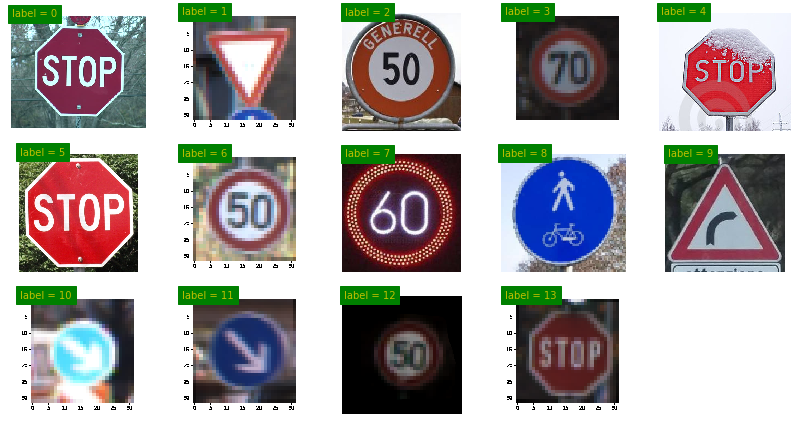

In [39]:
plot_sample_keras(img_array,np.arange(17))

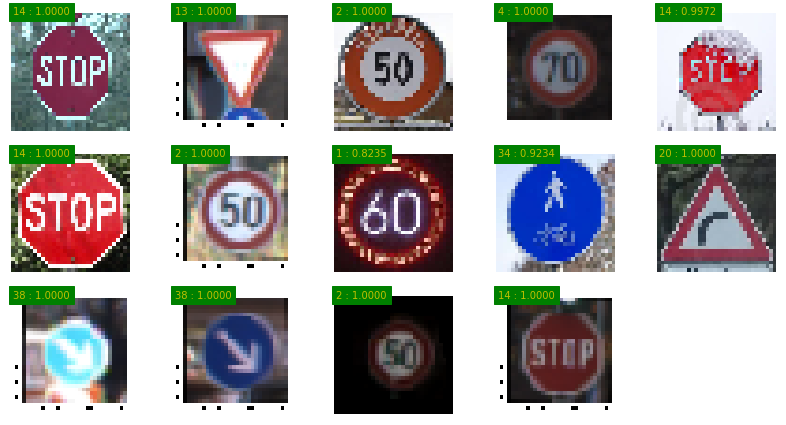

In [40]:
small_img_array = [img.resize((32,32)) for img in img_array]
X_new = np.array([np.array(img).astype('float32')/255 for img in small_img_array])
preds = model.predict(X_new)
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
fig = plt.figure(figsize = (14,10))
number_rows = 4
number_cols = 5
i = 0
for (img, (answer, confs)) in zip(small_img_array, zip(list(map(np.argmax, preds)), preds)):
    ax1 = plt.subplot(4,5,i+1)
    i +=1
    ax1.axis("off")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.imshow(img)
    plt.text(.1,.1, str(answer) + " : " + ("%0.4f" % confs[answer]),color='y',backgroundcolor='g')

In [41]:
true_labels = np.array([14, 13, 2, 4, 14, 14, 2, 3, 100, 20, 38, 38, 2, 14])
predicted_labels = np.array(list(map(np.argmax, preds)))
# compute descripancy with predicted labels
error = [1 for x in predicted_labels - true_labels if x!=0]
print("accuracy on new images is: {}".format( 1 - len(error)/len(predicted_labels)))

accuracy on new images is: 0.8571428571428572


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I have made a couple of photos locally, one of them, with the bike and walking man, represents a sign that is not included in the training set (one can not that effectively this sign was classified as a visually similar one in the training set). I have also downloaded some photos from the internet. The total set that I use for testing contains 14 elements. One of the image that I was especially interested in is the electronic 60 km/h sign, the ring around the 60 has a high intensity, and it would be nice to see how it is treated by the network. 

This obtained accuracy result is actually quite a good one since one of the images definitely had to be misclassified (the one with a bike and a pedestrian), since there are no such images in dataset. On the other hand the suggested label for image with pedestrian looks reasonable since the sign resemble an arrow on the blue background. Sign with glowing sixty was misclassified also. Overall the performance is good for an example project.

> Let us now visualize softmax probabilities

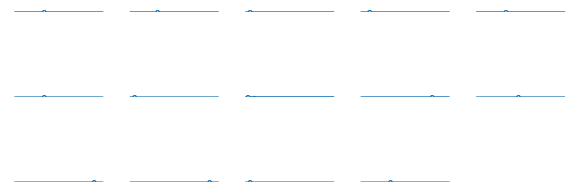

In [42]:
fig = plt.figure(figsize = (10,6))
number_rows = 4
number_cols = 5
i = 0
for pred in preds:
    ax1 = plt.subplot(4,5,i+1)
    i +=1
    ax1.axis("off")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.plot(range(len(pred)), pred)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Trained model performed really well signs that belonged to know classes (I took photos in Germany, so that was expected). It also performed well on US signs that I have downloaded form internet. Model, as expected, misclassified the unknow sign-type, but assigned it to the class that is visually similar.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer**

In [43]:
#load sign descriptions 
# Read sign names from csv
with open("signnames.csv", 'r') as f:
    reader = csv.reader(f)
    sign_names = list(reader)
    sign_names = np.asarray(sign_names[1:])

# Define a function to get sign name from label id
def get_sign_name(label):
    return sign_names[label, :][1]

In [44]:
def get_top_k(prediction,k):
    top_k = prediction.argsort()[-k:][::-1]
    for sign in top_k:
        print("\t\t\t\t: {}, with probability {}".format(get_sign_name(sign), prediction[sign]))

In [45]:
for true_label, prediction in zip(true_labels, preds):
    try:
        print("\"{}\" was classified as:".format(get_sign_name(true_label)))
        get_top_k(prediction,5)
    except IndexError:
        print("\"Brand new sign\" was classified as:")
        get_top_k(prediction,5)

"Stop" was classified as:
				: Stop, with probability 1.0
				: No entry, with probability 4.496624155924528e-14
				: Speed limit (80km/h), with probability 6.656866660822384e-15
				: No vehicles, with probability 6.217203198121725e-15
				: Bumpy road, with probability 4.4912901353457834e-15
"Yield" was classified as:
				: Yield, with probability 1.0
				: Speed limit (50km/h), with probability 6.72051367269986e-19
				: Ahead only, with probability 6.070621129871674e-19
				: Keep right, with probability 7.369557579918355e-20
				: Speed limit (60km/h), with probability 4.2510730996615157e-20
"Speed limit (50km/h)" was classified as:
				: Speed limit (50km/h), with probability 1.0
				: Speed limit (80km/h), with probability 1.1229028960873166e-15
				: Speed limit (60km/h), with probability 1.0248239982126755e-15
				: Wild animals crossing, with probability 2.339397570234322e-19
				: Bicycles crossing, with probability 7.967019150372896e-21
"Speed limit (70km/h)" was classifi

**Answer:**
We can see that on all signs that belonged to known classes model almost all the time was 98-100% certain. Except one case with the glowing 60kh/h sign. As expected model returned a visually similar class for a sign type that was not present in the training dataset, and the model belief was a bit lower than for the other type of signs

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.